#**Rafał Olech, gr.lab.02**
##**Temat: Projekt końcowy.**
###**Numer projektu:** 12
###**Temat projektu:** Dany jest kolorowy obraz, wykorzystaj histogram obrazu tak by poprawić jego jasność/kontrast według zadanego przez użytkownika kształtu odwzorowania.



###**1. Cel projektu:**
Celem projektu jest korekcja danego obrazu pod względem kontrastu/jasności w sposób określony przez użytkownika. Użytkownik ma do wyboru różne przekształcenia obrazu aby uzyskać jak najbardziej zbliżony efekt to założonego.

###**2. Rozwiązanie:**

####**2.1. Dodanie potrzebnych importów:**
Na samym początku programu następuje dodanie importów wszystkich potrzebnych bibliotek, które będą wykorzystywane w dalszej części projektu.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import skimage.color
import skimage.io
from scipy import ndimage
from scipy import misc
import matplotlib.cm as cm
import scipy.misc
import scipy.ndimage.filters
from PIL import Image
import skimage.filters
from math import sqrt,exp
from skimage.color import rgb2gray
from numpy import array
import skimage.morphology as morph
import math
from IPython.display import display, Markdown
from glob2 import glob
import colorsys
from __future__ import print_function
from builtins import input
import cv2 as cv
import argparse
import matplotlib
from skimage import data, img_as_float
from skimage import exposure
matplotlib.rcParams['font.size'] = 8


####**2.2. Wczytanie i wyświetlenie wybranych zdjęć:**
Do testowania programu zostało wybranych 5 obrazów. Jeden obraz RGB o przeważającej ilości odcieni o ciemnych barwach przedstawiający gwiazdy. Jeden obraz RGB o przeważającej ilości odcieni o jasnej barwie przedstawiający budynek. Jeden obraz czarno-biały przedstawiający mocno skontrastowany portret. Jeden obraz RGB o bardzo niskim kontraście przedstawiającym las. Jeden obraz RGB, który jest bardzo ostry i zawiera dużo szczegółów przedstawiający księżyc.

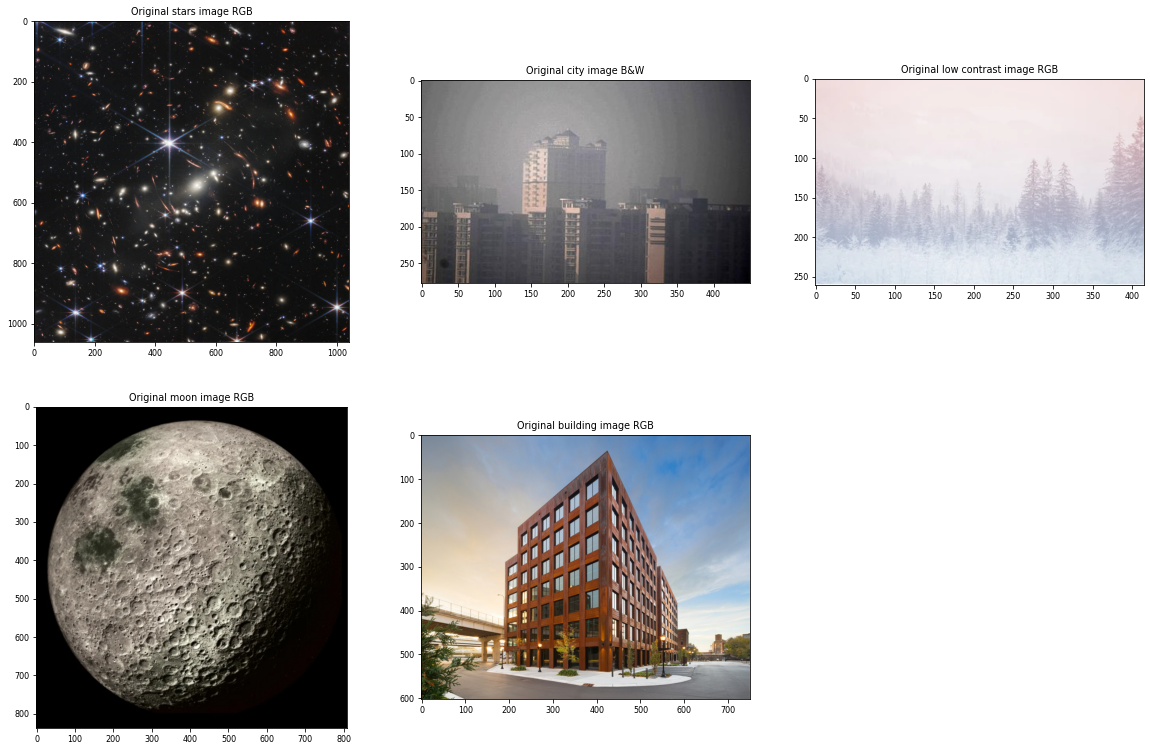

In [2]:
image_stars = skimage.io.imread(r"/content/stars.jpg")
image_building = skimage.io.imread(r"/content/building.jpg")
image_city = skimage.io.imread(r"/content/city.png")
image_low_contrast = skimage.io.imread(r"/content/low_contrast.PNG")
image_moon = skimage.io.imread(r"/content/moon2.PNG")

image_to_correct = image_moon


f = plt.figure(figsize=(20,13))
f.add_subplot(231)
plt.imshow(image_stars)
plt.title("Original stars image RGB")
f.add_subplot(232)
plt.imshow(image_city)
plt.title("Original city image B&W")
f.add_subplot(233)
plt.imshow(image_low_contrast)
plt.title("Original low contrast image RGB")
f.add_subplot(234)
plt.imshow(image_moon)
plt.title("Original moon image RGB")
f.add_subplot(235)
plt.imshow(image_building)
plt.title("Original building image RGB")
plt.show()

####**2.3. Zamiana obrazu RGB na HSL:**
Pierwszym etapem obróbki obrazu jest zamiana reprezentacji kolorów RGB na HSL. HSL oznacza odcień, nasycenie i jasność: Hue (odcień), Saturation (nasycenie koloru), Lightness (jasność).
Zamiana modelu kolorów jest potrzebna aby w dalszej kolejności wyświetlać histogram dla poszczególnych obrazów od zmiennej L. Następnie wszelkie korekcje i przetwarzanie będzie odbywało się właśnie na tej składowej obrazu. W przypadku obrazów RGB konieczne było by przetwarzanie równocześnie na trzech kanałach a nie tak jak w HSL tylko na jednym.


Do konwersji obrazu z RGB na HSL utworzyłem funkcję create_hls_array(). Najpierw za pomocą funkcji load() uzyskujemy tablicę pikseli obrazu przekazanego jako parametr. Tworzona jest pusta tablica hls_array. Pierwsze dwa wymiary to wysokość i długość obrazu, a trzeci to stały rozmiar dla wartości HSL. Tablica jest typu float ponieważ wartości nasycenia i jasności mogą zawierać ułamki dziesiętne. Następnie iterując po wierszach i kolumnach pikseli, uzyskujemy RGB dla każdego piksela. Do konwersji na HSL używana jest funkcja rgb_to_hsl() z biblioteki colorsys. Argumenty są wartościami zmiennoprzecinkowymi z przedziału od 0 do 1, a nie liczbami całkowitymi z przedziału od 0 do 255, więc każda wartość musi być podzielona przez 255. Na koniec uzupełniana jest tablica hls_array i jest zwracana.


In [33]:
def create_hls_array(image):

    pixels = image.load()
    hls_array = np.empty(shape=(image.height, image.width, 3), dtype=float)

    for row in range(0, image.height):
        for column in range(0, image.width):
            rgb = pixels[column, row]
            hls = colorsys.rgb_to_hls(rgb[0]/255, rgb[1]/255, rgb[2]/255)
            hls_array[row, column, 0] = hls[0]
            hls_array[row, column, 1] = hls[1]
            hls_array[row, column, 2] = hls[2]
    l_min = np.min(hls_array[:, :, 1])        
    l_max = np.max(hls_array[:, :, 1])
    print(l_min)
    print(l_max)
    return hls_array

Wyświetlenie obrazu HSL oraz jego składowych H, S, L:

0.0
0.9941176470588236


Text(0.5, 1.0, 'Saturation')

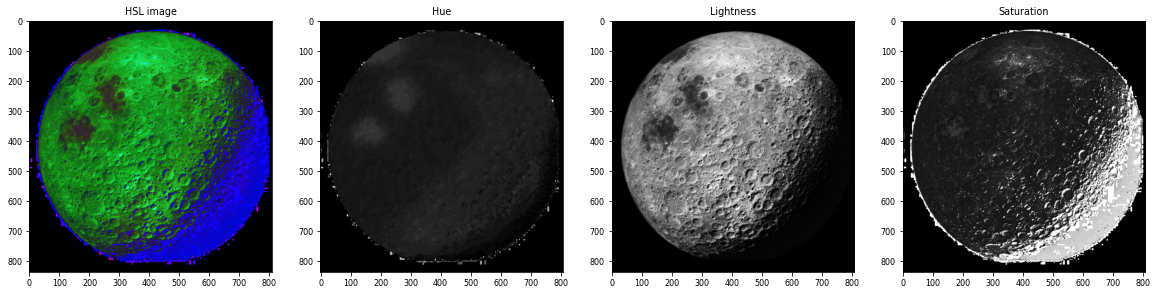

In [34]:
image = Image.open("/content/moon2.PNG")
hls_array = create_hls_array(image)
f = plt.figure(figsize=(20,13))
f.add_subplot(141)
plt.imshow(hls_array, cmap='gray')
plt.title("HSL image")
f.add_subplot(142)
plt.imshow(hls_array[:, :, 0], cmap='gray')
plt.title("Hue")
f.add_subplot(143)
plt.imshow(hls_array[:, :, 1], cmap='gray')
plt.title("Lightness")
f.add_subplot(144)
plt.imshow(hls_array[:, :, 2], cmap='gray')
plt.title("Saturation")

**2.4. Wyświetlenie histogramu dla kanału L:**

Kolejnym etapem jest wyświetlenie histogramu dla kanału L czyli lightness dla wybranego obrazu. Wartości pikselów znajdują się w przedziale od 0 do 1. Histogram znajdował się tylko na danym zakresie a więc rozszerzyłem go rozciągając przedział składowej x na przedział od 0 do 255. 

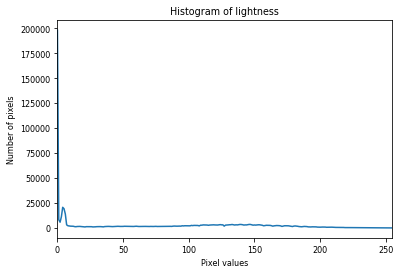

In [35]:
plt.figure() 
hist,bin = np.histogram(hls_array[:, :, 1], 256,[0.0, 1.0]) 
plt.xlim([0.0, 255.0]) 
plt.plot(hist)
plt.title('Histogram of lightness') 
plt.xlabel("Pixel values")
plt.ylabel("Number of pixels")
plt.show( )


**2.5. Zamiana obrazu HSL na RGB:**

Po całkowitym przetworzeniu obrazu HSL w sposób zadany przez użytkownika należy przywrócić obrazowi jego pierwotny model kolorów czyli RGB aby otrzymać obraz wyjściowy, który jest kolorowy.

Do konwersji obrazu z HSL na RGB służy funkcja image_from_hls_array(). Funkcja jako parametr przyjmuje przetworzony obraz HSL. Na początku tworzony jest obraz o takim samym rozmiarze jak tablica przekazana w parametrze. Następnie w pętlach dla wierszy i kolumn wywoływana jest funkcja colorsys.hls_to_rgb() aby uzyskać wartości RGB. W RGB piksele mają wartości od 0 do 255, a więc konieczne jest przemnożenie przez 255. Na koniec zwracany jest obraz RGB.


In [36]:
def image_from_hls_array(hls_array):

    new_image = Image.new("RGB", (hls_array.shape[1], hls_array.shape[0]))

    for row in range(0, new_image.height):
        for column in range(0, new_image.width):

            rgb = colorsys.hls_to_rgb(hls_array[row, column, 0],
                                      hls_array[row, column, 1],
                                      hls_array[row, column, 2])

            rgb = (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
            new_image.putpixel((column, row), rgb)
    plt.figure()
    plt.title("RGB image after correction")
    plt.imshow(new_image)

    return new_image

**2.6. Funkcja wykładnicza:**

Pierwszym z możliwych do wyboru przez użytkownika sposobów na zmianę kontrastu/jasności jest wykorzystanie korekcji gamma.
Funkcja gamma czyli odwzorowanie wykładnicze określa się wzorem:

s=c⋅r^γ,

gdzie c i γ są stałymi dodatnimi.

W programie za korekcję funkcją wykładniczą odpowiedzialna jest funkcja gamma_function_HSL(). Jako wynik wywołania funkcji wyświetlana jest składowa L obrazu przed korekcją  oraz jego histogram, a także wyświetlana jest składowa L obrazu po korekcji oraz jego histogram. Wyświetlane są także dwa obrazy, które odpowiednio przedstawiają oryginalny obraz RGB przez korekcją oraz zpowrotem skonwertowany z HSL do RGB obraz po korekcji. Użytkownik wybierając tą funkcję może wybrać wartości z przedziału od 0.0 do 3.0.


In [37]:
def gamma_function_HSL(img, gamma): # >1 jasniejsze,  <1 ciemniejsze  0.0 - 3.0
  f = plt.figure(figsize=(20,5))
  f.add_subplot(121)
  plt.imshow(img, cmap='gray')
  plt.title("Lightness before correction")

  f.add_subplot(122)
  hist,bin = np.histogram(img, 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness before correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  hls_array2 = np.zeros(hls_array.shape, hls_array.dtype)
  for row in range(0, hls_array.shape[0]):
    for column in range(0, hls_array.shape[1]):
        hls_array2[row, column, 0] = hls_array[row, column, 0]
        hls_array2[row, column, 1] = hls_array[row, column, 1]
        hls_array2[row, column, 2] = hls_array[row, column, 2]


  for y in range(hls_array2.shape[0]):
      for x in range(hls_array2.shape[1]):
         hls_array2[y,x,1] = np.clip(1.0*(hls_array[y,x,1]/1.0) ** gamma, 0.0, 1.0)
  
  f2 = plt.figure(figsize=(20,5))
  f2.add_subplot(121)
  plt.imshow(hls_array2[:, :, 1], cmap='gray') 
  plt.title("Lightness after gamma correction")
  f2.add_subplot(122)
  hist,bin = np.histogram(hls_array2[:, :, 1], 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness after gamma correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  plt.figure()
  plt.imshow(image_to_correct) 
  plt.title("RGB image before correction")

  image_from_hls_array(hls_array2)

**2.7. Funkcja logarytmiczna:**

Kolejnym z możliwych do wyboru przez użytkownika sposobów na zmianę kontrastu/jasności jest wykorzystanie funkcji logarytmicznej.
Funkcja logarytmiczna określona jest wzorem:

s=c⋅log⁡(1+r),

gdzie c jest stałą, a r≥0.


W programie za korekcję funkcją logarytmiczną odpowiedzialna jest funkcja log_function_HSL(). Jako wynik wywołania funkcji wyświetlana jest składowa L obrazu przed korekcją  oraz jego histogram, a także wyświetlana jest składowa L obrazu po korekcji oraz jego histogram. Wyświetlane są także dwa obrazy, które odpowiednio przedstawiają oryginalny obraz RGB przez korekcją oraz zpowrotem skonwertowany z HSL do RGB obraz po korekcji. W programie zamiast brać do wzoru maksymalną wartość z tablicy wejściowego obrazu, która jest składową stałej c we wzorze użytkownik aby mieć większą kontrolę nad korekcją,  sam może podać wartość parametru m z przedziału od 0.0 do 1.0.




In [51]:
def log_function_HSL(img, m): #0.0-1.0
  
  f = plt.figure(figsize=(20,5))
  f.add_subplot(121)
  plt.imshow(img, cmap='gray')
  plt.title("Lightness before correction")

  f.add_subplot(122)
  hist,bin = np.histogram(img, 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness before correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  hls_array2 = np.zeros(hls_array.shape, hls_array.dtype)
  for row in range(0, hls_array.shape[0]):
    for column in range(0, hls_array.shape[1]):
        hls_array2[row, column, 0] = hls_array[row, column, 0]
        hls_array2[row, column, 1] = hls_array[row, column, 1]
        hls_array2[row, column, 2] = hls_array[row, column, 2]

  c = 1.0/(np.log(1 + np.max(hls_array[:, :, 1])))
  c2 = 1.0/(np.log(1 + m))
  
  hls_array2[:,:,1] = c2 * np.log(1 + hls_array[:, :, 1])


  f2 = plt.figure(figsize=(20,5))
  f2.add_subplot(121)
  plt.imshow(hls_array2[:,:,1], cmap='gray') 
  plt.title("Lightness after log correction")
  f2.add_subplot(122)
  hist,bin = np.histogram(hls_array2[:,:,1], 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness after log correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  plt.figure()
  plt.imshow(image_to_correct) 
  plt.title("RGB image before correction")

  image_from_hls_array(hls_array2)

**2.8. Funkcja odcinkowo-liniowa:**

Kolejnym z możliwych do wyboru przez użytkownika sposobów na zmianę kontrastu jest wykorzystanie funkcji odcinkowo-liniowej.
Funkcja ta określona jest wzorem: 
s=c⋅log⁡(1+r),
gdzie c jest stałą, a r≥0.

Za pomocą funkcji odcinkowo-liniowych, które mogą być dowolnie skomplikowane można zwiększyć kontrast. Sposób ten znajduje szczególne zastosowanie w przypadku obrazów o małym kontraście wynikającym ze słabego oświetlenia.


W programie za zwiększenie kontrastu funkcją odcinkowo-liniową odpowiedzialna jest funkcja sectionalLinear_function_HSL(). Jako wynik wywołania funkcji wyświetlana jest składowa L obrazu przed korekcją  oraz jego histogram, a także wyświetlana jest składowa L obrazu po korekcji oraz jego histogram. Wyświetlane są także dwa obrazy, które odpowiednio przedstawiają oryginalny obraz RGB przez korekcją oraz zpowrotem skonwertowany z HSL do RGB obraz po korekcji. Użytkownik sam wprowadza wartości współrzędnych punktów (r1, s1) oraz (r2, s2) które mieszczą się w przedziale od 0.0 do 1.0.


In [39]:
def sectionalLinear_function_HSL(img, r1, s1, r2, s2): # 0.0-1.0
  f = plt.figure(figsize=(20,5))
  f.add_subplot(121)
  plt.imshow(img, cmap='gray')
  plt.title("Lightness before correction")

  f.add_subplot(122)
  hist,bin = np.histogram(img, 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness before correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  hls_array2 = np.zeros(hls_array.shape, hls_array.dtype)
  for row in range(0, hls_array.shape[0]):
    for column in range(0, hls_array.shape[1]):
        hls_array2[row, column, 0] = hls_array[row, column, 0]
        hls_array2[row, column, 1] = hls_array[row, column, 1]
        hls_array2[row, column, 2] = hls_array[row, column, 2]
  
  def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1): 
        return (s1 / r1)*pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
    else:
        return ((1 - s2)/(1 - r2)) * (pix - r2) + s2
    
  pixelVal_vec = np.vectorize(pixelVal)
  
  hls_array2[:, :, 1] = pixelVal_vec(img, r1, s1, r2, s2)

  #contrast_stretched = pixelVal_vec(img, r1, s1, r2, s2)

  f2 = plt.figure(figsize=(20,5))
  f2.add_subplot(121)
  plt.imshow(hls_array2[:, :, 1], cmap='gray') 
  plt.title("Lightness after correction")
  f2.add_subplot(122)
  hist,bin = np.histogram(hls_array2[:,:,1], 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness after correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  plt.figure()
  plt.imshow(image_to_correct) 
  plt.title("RGB image before correction")

  image_from_hls_array(hls_array2)

**2.9. Funkcja liniowa:**

Kolejnym z możliwych do wyboru przez użytkownika sposobów na zmianę kontrastu/jasności jest wykorzystanie funkcji liniowej.
Funkcja ta określona jest wzorem: 

g(x)=a⋅f(x)+b,

gdzie a>0.

W powyższym, wzorze g(x) są to piksele obrazu wyjściowego, natomiast f(x) są to piksele obrazu wejściowego. Parametry a oraz b są odpowiednio odpowiedzialne za zmianę kontrastu oraz jasności.

W programie za zmianę kontrastu oraz jasności funkcją liniową odpowiedzialna jest funkcja linear_function_HSL(). Jako wynik wywołania funkcji wyświetlana jest składowa L obrazu przed korekcją  oraz jego histogram, a także wyświetlana jest składowa L obrazu po korekcji oraz jego histogram. Wyświetlane są także dwa obrazy, które odpowiednio przedstawiają oryginalny obraz RGB przez korekcją oraz zpowrotem skonwertowany z HSL do RGB obraz po korekcji. Użytkownik sam wprowadza wartości współczynników a i b.


In [40]:
def linear_function_HSL(img, a, b):
  image_test = hls_array

  f = plt.figure(figsize=(20,5))
  f.add_subplot(121)
  plt.imshow(img, cmap='gray')
  plt.title("Lightness before correction")

  f.add_subplot(122)
  hist,bin = np.histogram(img, 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness before correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )


  hls_array2 = np.zeros(hls_array.shape, hls_array.dtype)

  for row in range(0, hls_array.shape[0]):
      for column in range(0, hls_array.shape[1]):
          hls_array2[row, column, 0] = hls_array[row, column, 0]
          hls_array2[row, column, 1] = hls_array[row, column, 1]
          hls_array2[row, column, 2] = hls_array[row, column, 2]


  for y in range(image_test.shape[0]):
      for x in range(image_test.shape[1]):
        hls_array2[y,x,1] = np.clip(a*hls_array[y,x,1]+b, 0.0, 1.0) 


  f2 = plt.figure(figsize=(20,5))
  f2.add_subplot(121)
  plt.imshow(hls_array2[:, :, 1], cmap='gray') 
  plt.title("Lightness after correction")
  f2.add_subplot(122)
  hist,bin = np.histogram(hls_array2[:,:,1], 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness after correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  plt.figure()
  plt.imshow(image_to_correct) 
  plt.title("RGB image before correction")

  image_from_hls_array(hls_array2)

**2.10. Funkcja kwadratowa:**

Kolejnym z możliwych do wyboru przez użytkownika sposobów na zmianę kontrastu/jasności jest wykorzystanie funkcji kwadratowej.
Funkcja ta określona jest wzorem: 

g(x)=a⋅x^2+b⋅x+c,

gdzie a>0, b>0.

W powyższym, wzorze g(x) są to piksele obrazu wyjściowego, natomiast x są to piksele obrazu wejściowego. Parametry a oraz b są odpowiednio odpowiedzialne za zmianę kontrastu oraz jasności.

W programie za zmianę kontrastu oraz jasności funkcją kwadratową odpowiedzialna jest funkcja quadratic_function_HSL(). Jako wynik wywołania funkcji wyświetlana jest składowa L obrazu przed korekcją  oraz jego histogram, a także wyświetlana jest składowa L obrazu po korekcji oraz jego histogram. Wyświetlane są także dwa obrazy, które odpowiednio przedstawiają oryginalny obraz RGB przez korekcją oraz zpowrotem skonwertowany z HSL do RGB obraz po korekcji. Użytkownik sam wprowadza wartości współczynników a, b i c.



In [41]:
def quadratic_function_HSL(img, a, b, c):
  image_test = hls_array

  f = plt.figure(figsize=(20,5))
  f.add_subplot(121)
  plt.imshow(img, cmap='gray')
  plt.title("Lightness before correction")

  f.add_subplot(122)
  hist,bin = np.histogram(img, 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness before correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )


  hls_array2 = np.zeros(hls_array.shape, hls_array.dtype)

  for row in range(0, hls_array.shape[0]):
      for column in range(0, hls_array.shape[1]):
          hls_array2[row, column, 0] = hls_array[row, column, 0]
          hls_array2[row, column, 1] = hls_array[row, column, 1]
          hls_array2[row, column, 2] = hls_array[row, column, 2]


  for y in range(image_test.shape[0]):
      for x in range(image_test.shape[1]):
        hls_array2[y,x,1] = np.clip(a*(hls_array[y,x,1]*hls_array[y,x,1])+b*hls_array[y,x,1]+c, 0.0, 1.0) 


  f2 = plt.figure(figsize=(20,5))
  f2.add_subplot(121)
  plt.imshow(hls_array2[:, :, 1], cmap='gray') 
  plt.title("Lightness after correction")
  f2.add_subplot(122)
  hist,bin = np.histogram(hls_array2[:,:,1], 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness after correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  plt.figure()
  plt.imshow(image_to_correct) 
  plt.title("RGB image before correction")

  image_from_hls_array(hls_array2)

**2.11. Przesunięcia histogramu:**

Kolejnym z możliwych do wyboru przez użytkownika sposobów na zmianę kontrastu jest wykorzystanie przesunięcia histogramu. Użytkownik decyduje w jaki sposób chce przesunąć histogram. Aby pomóc użytkownikowi w wyborze przesunięcia za pomocą utworzonej funkcji suggestedHistogramShifts()  wyświetlanych jest kilka gaussowskich funkcji, które w sposób poglądowy pokazują miejsca docelowego przesunięcia. W funkcji tej zostało przedstawionych 6 różnych przesunięć. Funkcje gaussowskie są kolejne nazwane VeryDark(), Dark(), SlightlyDark(), SlightlyBright(), Bright(), VeryBright(). Im bardziej w lewą stronę przesuwa się histogram tym obraz jest ciemniejszy, natomiast im bardziej w prawo tym obraz jest jaśniejszy.

In [42]:
# Gaussian Function:
def G(x, mean, std):
    return np.exp(-0.5*np.square((x-mean)/std))

def VeryDark(x, M):
    return G(x, 0, M/6)

def Dark(x, M):
    return G(x, M/2, M/6)

def SlightlyDark(x, M):
    return G(x, 5*M/6, M/6)
    
def SlightlyBright(x, M):
    return G(x, M+(255-M)/6, (255-M)/6)

def Bright(x, M):
    return G(x, M+(255-M)/2, (255-M)/6)

def VeryBright(x, M):
    return G(x, 255, (255-M)/6)

Wyświetlenie poglądowych funkcji przesunięć znajduje się w funkcji suggestedHistogramShifts().

In [43]:
def suggestedHistogramShifts():
  M = 128
  x = np.arange(0, 255)
    
  VD = VeryDark(x, M)
  Da = Dark(x, M)
  SD = SlightlyDark(x, M)
  SB = SlightlyBright(x, M)
  Br = Bright(x, M)
  VB = VeryBright(x, M)

  plt.figure(figsize=(20,5))
  plt.plot(x, VD, 'k-',label='1', linewidth=2)#VD
  plt.plot(x, Da, 'g-',label='2', linewidth=2)#
  plt.plot(x, SD, 'b-',label='3', linewidth=2)#
  plt.plot(x, SB, 'r-',label='4', linewidth=2)#
  plt.plot(x, Br, 'c-',label='5', linewidth=2)#
  plt.plot(x, VB, 'y-',label='6', linewidth=2)#
  plt.legend()
  plt.xlim(0, 255)
  plt.ylim(0.0, 1.01)
  plt.xlabel('Pixel intensity')
  plt.ylabel('Degree of membership')
  plt.show()

Następnie po wyświetleniu poglądowych przesunieć wywoływana jest funkcja histogramShifts(). Jako parametr funkcja przyjmuje numer przesunięcia wybranego przez użytkownika. Następnie w zależności od wybranego przesunięcia histogramu uruchamiana jest funkcja liniowa na konkretnych parametrach.

In [44]:
def histogramShifts(shiftNumber):
  if(shiftNumber=='1'):
    linear_function_HSL(hls_array[:, :, 1], 1.0, -0.1)
  
  elif(shiftNumber=='2'):
    linear_function_HSL(hls_array[:, :, 1], 1.0, 0.1)

  elif(shiftNumber=='3'):
    linear_function_HSL(hls_array[:, :, 1], 1.0, 0.3)  

  elif(shiftNumber=='4'):
    linear_function_HSL(hls_array[:, :, 1], 1.0, 0.5)

  elif(shiftNumber=='5'):
    linear_function_HSL(hls_array[:, :, 1], 1.0, 0.7)

  elif(shiftNumber=='6'):
    linear_function_HSL(hls_array[:, :, 1], 1.0, 0.9) 

**2.12. Rozszerzenie histogramu:**

Dla porównania użytkownik ma do wyboru jeszcze poprawę kontrastu za pomocą bibliotecznej funkcji rescale_intensity(). Funkcja ta zwraca obraz po rozciągnięciu lub zmniejszeniu jego poziomów intensywności. Instensywność obrazu jest rozciągana do granic  in_range i out_range.

Wykorzystanie tej funkcji w programie znajduję się w funkcji contrastStretching().



In [45]:
def contrastStretching(img): 
  f = plt.figure(figsize=(20,5))
  f.add_subplot(121)
  plt.imshow(img, cmap='gray')
  plt.title("Lightness before correction")

  f.add_subplot(122)
  hist,bin = np.histogram(img, 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness before correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  hls_array2 = np.zeros(hls_array.shape, hls_array.dtype)

  for row in range(0, hls_array.shape[0]):
      for column in range(0, hls_array.shape[1]):
          hls_array2[row, column, 0] = hls_array[row, column, 0]
          hls_array2[row, column, 1] = hls_array[row, column, 1]
          hls_array2[row, column, 2] = hls_array[row, column, 2]

  p3, p99 = np.percentile(img, (2.0, 98))
  #img_rescale2 = exposure.rescale_intensity(img, in_range=(p3, p99))
  hls_array2[:, :, 1] = exposure.rescale_intensity(img, in_range=(p3, p99))


  f2 = plt.figure(figsize=(20,5))
  f2.add_subplot(121)
  plt.imshow(hls_array2[:, :, 1], cmap='gray') 
  plt.title("Lightness after correction")
  f2.add_subplot(122)
  hist,bin = np.histogram(hls_array2[:,:,1], 256,[0.0, 1.0]) 
  plt.xlim([0.0, 255.0]) 
  plt.plot(hist)
  plt.title('Histogram of lightness after correction') 
  plt.xlabel("Pixel values")
  plt.ylabel("Number of pixels")
  plt.show( )

  plt.figure()
  plt.imshow(image_to_correct) 
  plt.title("RGB image before correction")

  image_from_hls_array(hls_array2)

**2.13. Obsługa użytkownika:**


In [72]:
name = input("Wybierz typ fukcji: 1-funkcja wykł.(gamma), 2-fukcja log.,3-funkcja odcinkowo-liniowa, 4-funkcja liniowa, 5-funkcja kwadratowa, 6-przesunięcia histogramu, 7-rozciągnięcie histogramu")

Wybierz typ fukcji: 1-funkcja wykł.(gamma), 2-fukcja log.,3-funkcja odcinkowo-liniowa, 4-funkcja liniowa, 5-funkcja kwadratowa, 6-przesunięcia histogramu, 7-rozciągnięcie histogramu7


**2.14. Wybór użytkownika:**

Po wybraniu przez użytkownika metody poprawy kontrastu/jasności obrazu uruchamiana jest odpowiednia funkcja. Najczęściej użytkownik proszony jest o podanie potrzebnych parametrów.

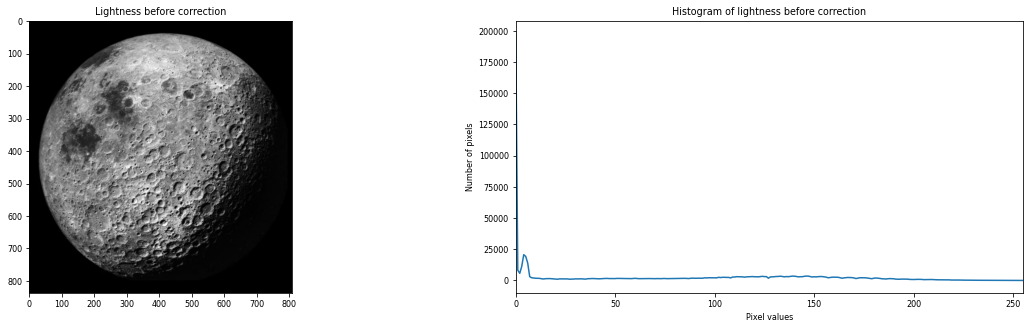

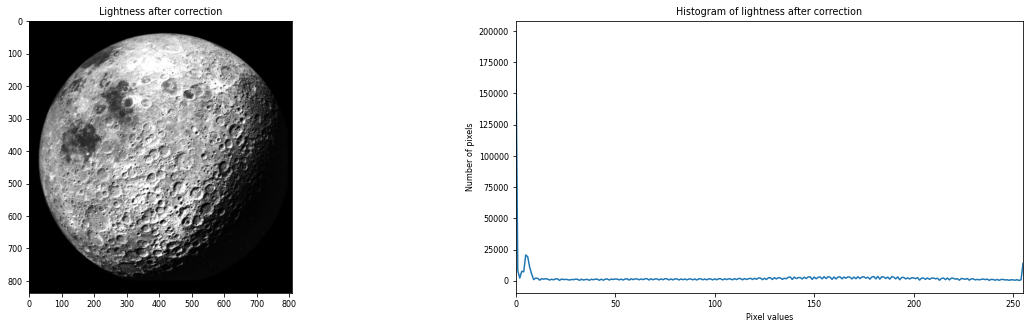

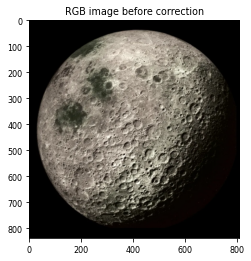

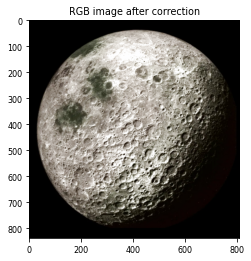

In [73]:
if(name=='1'):
  gamma_value = float(input("Podaj wartość gammy: "))
  gamma_function_HSL(hls_array[:, :, 1], gamma_value)

elif(name=='2'):
  m = float(input("Podaj wartość współczynnika m: [0.0-1.0]"))
  log_function_HSL(hls_array[:, :, 1], m)

elif(name=='3'):
  r1 = float(input("Podaj wartość współczynnika r1 [0.0-1.0]: "))
  s1 = float(input("Podaj wartość współczynnika s1 [0.0-1.0]: "))
  r2 = float(input("Podaj wartość współczynnika r2 [0.0-1.0]: "))
  s2 = float(input("Podaj wartość współczynnika s2 [0.0-1.0]: "))
  sectionalLinear_function_HSL(hls_array[:, :, 1], r1, s1, r2, s2)

elif(name=='4'):
  a = float(input("Podaj wartość współczynnika a [0.0-10.0]: "))
  b = float(input("Podaj wartość współczynnika b [0.0-1.0]: "))
  linear_function_HSL(hls_array[:, :, 1], a, b)

elif(name=='5'):
  a2 = float(input("Podaj wartość współczynnika a [0.0-10.0]: "))
  b2 = float(input("Podaj wartość współczynnika b [0.0-10.0]: "))
  c2 = float(input("Podaj wartość współczynnika c [0.0-1.0]: "))
  quadratic_function_HSL(hls_array[:, :, 1], a2, b2, c2)

elif(name=='6'):
  print("Proponowane przesunięcia histogramu: ") 
  suggestedHistogramShifts() 
  print("")

  shiftNumber = input("Wybierz numer przesunięcia histogramu [1-6]: ")
  print("")
  histogramShifts(shiftNumber)
 

elif(name=='7'):
  contrastStretching(hls_array[:, :, 1])
   